# SOLUTION: Model Building, Scoring & Evaluating (XGBoost)

## Imports

In [2]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T

from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.metrics import *

import json
import pandas as pd
import seaborn as sns

## Create Snowpark Session

In [3]:
with open('creds.json') as f:
    connection_parameters = json.load(f)

In [4]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "HOL_DB"."PUBLIC"
Current Warehouse: "HOL_WH"


# Model Building

In [5]:
train_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN')
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')

# SOLUTION: Train an XGBoost Model

In [6]:
feature_cols = train_sdf.columns
feature_cols.remove('TARGET')
feature_cols.remove('ID')
target_col = 'TARGET'

xgbmodel = XGBClassifier(
    random_state=123, 
    input_cols=feature_cols, 
    label_cols=target_col, 
    output_cols='PREDICTION'
    )
xgbmodel.fit(train_sdf)

The version of package 'numpy' in the local environment is 1.26.1, which does not fit the criteria for the requirement 'numpy==1.26.2'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'xgboost' in the local environment is 1.7.6, which does not fit the criteria for the requirement 'xgboost==1.7.3'. Your UDF might not work when the package version is different between the server and your local environment.


[08:16:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



The fitted model can be retrieved as an XGB object

In [7]:
xgbmodel_local = xgbmodel.to_xgboost()

<Axes: >

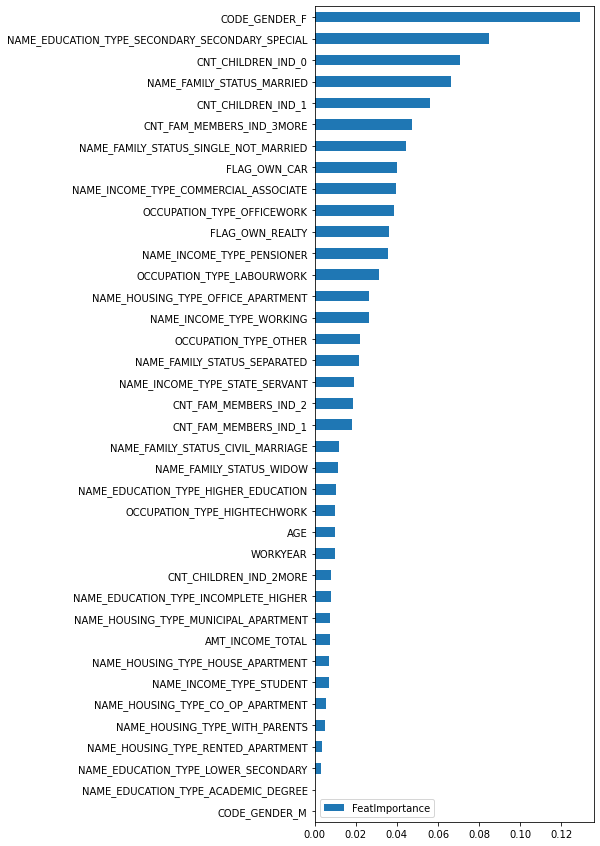

In [8]:
# Plot feature importance
feat_importance = pd.DataFrame(xgbmodel_local.feature_importances_,xgbmodel_local.feature_names_in_,columns=['FeatImportance'])
feat_importance.sort_values('FeatImportance').plot.barh(y='FeatImportance', figsize=(5,15))

# Model Scoring

# SOLUTION: Use the fitted XGBoost Model to score a Snowpark DataFrame

In [9]:
scored_sdf = xgbmodel.predict(test_sdf)
scored_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TEST_SCORED', mode='overwrite')
session.table('CREDIT_RISK_PREPARED_BALANCED_TEST_SCORED').show()

The version of package 'numpy' in the local environment is 1.26.1, which does not fit the criteria for the requirement 'numpy==1.26.2'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'xgboost' in the local environment is 1.7.6, which does not fit the criteria for the requirement 'xgboost==1.7.3'. Your UDF might not work when the package version is different between the server and your local environment.


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Model Evaluation

# Solution: Evaluate model performance

Acccuracy: 0.990364


The version of package 'numpy' in the local environment is 1.26.1, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.
DataFrame.flatten() is deprecated since 0.7.0. Use `DataFrame.join_table_function()` instead.


Precision: 0.987362413371382


The version of package 'numpy' in the local environment is 1.26.1, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


Recall: 0.9912011458972785


The version of package 'numpy' in the local environment is 1.26.1, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


F1: 0.98927805575411


The version of package 'numpy' in the local environment is 1.26.1, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'numpy' in the local environment is 1.26.1, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


<Axes: >

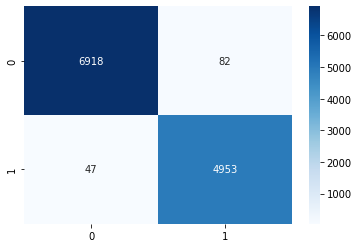

In [10]:
print('Acccuracy:', accuracy_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('Precision:', precision_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('Recall:', recall_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('F1:', f1_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))

# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=scored_sdf, y_true_col_name='TARGET', y_pred_col_name='PREDICTION')

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

In [ ]:
session.close()